# Github comments sentiment anlysis via NLTK tool and GitHub API

NLTK was developed by Bird et al. It uses multiple corpora in its development. We use an API provided in www.text-processing.com to call this tool. For each text, it also returns a sentiment label (positive/neutral/negative).

# Via $curl$

In [ ]:
! curl -H 'Accept: application/vnd.github.v3+json' https://api.github.com/repos/octocat/hello-world/issues/comments

In [ ]:
! curl -d "text=Let's try again via this awesome Issue tacker... \n" http://text-processing.com/api/sentiment/

# Via Python $requests$ lib

In [ ]:
! pip install requests

In [ ]:
import requests

In [ ]:
query = {'text':"Let's try again via awesome Issue tacker...\n"}
response = requests.post("http://text-processing.com/api/sentiment/", data=query)
print(response.json())

{'probability': {'neg': 0.31451181582793397, 'neutral': 0.33122764068566357, 'pos': 0.685488184172066}, 'label': 'pos'}


# GitHub comments analysis

Import Pyhton API library

In [ ]:
import requests

Implement helping function to analyze one page of GitHub comments.
The following parameters are used:

*   $username$ - GitHub alias of the repository owner;
*   $repo$ - GitHub repository name;
*   $per\_page$ - number of comments on the page (from 0 to 100);
*   $page$ - Page number of the results to fetch;
*   $print\_comments$ - boolean flag. If it is set to True, each fetched comment and its analysis will be printed.
*   $print\_stage\_results$ - boolean flag. If it's set to True, final statistics of the analyzed comments will be printend in the end.



In [ ]:
# using NLTK

def analyze_comments_page(username, repo, per_page, page, print_comments, print_stage_results):
  total = 0
  pos = 0
  neg = 0
  neut = 0

  print("Processing page #"+str(page)+"...\n")
  query={'per_page': per_page, 'page': page}
  resp = requests.get("https://api.github.com/repos/"+username+"/"+repo+"/issues/comments", params=query)
  comments = resp.json()

  for comment in comments:
    total=total+1
    if print_comments:
      print(str(total) + '. ' + comment.get("body"))

    query = {'text' : comment.get("body")}
    response = requests.post("http://text-processing.com/api/sentiment/", data=query)
    if print_comments:
      print(response.json())
      print('\n')

    sentiment = response.json().get("label")
    if sentiment=='pos':
      pos=pos+1
    elif sentiment=='neg':
      neg=neg+1
    else:
      neut=neut+1
  
  if print_stage_results:
    print('Processed: '+str(total))
    print('Positive comments: '+str(pos))
    print('Negative comments: '+str(neg))
    print('Neutral comments: '+str(neut))

  return total, pos, neg, neut

Implementation of the final function to be used. It analyzes the given number of comments in the given repository. The following parameters are used:

*   $username$ - GitHub alias of the repository owner;
*   $repo$ - GitHub repository name;
*   $comments\_to\_process$ - number of comments to be fetched.
*   $print\_comments$ - boolean flag. If it is set to True, each fetched comment and its analysis will be printed.
*   $print\_stage\_results$ - boolean flag. If it's set to True, statistics of the analyzed comments on each stage(for each fetched page) will be printend.

Function returns tuple of number of fetched in total(if number of comments in repo is less than $comments\_to\_process$ all the available comments will be processed), positive, negative and neutral comments.

In [ ]:
def analyze_comments(username, repo, comments_to_process, print_comments, print_stage_results):
  total = 0
  pos = 0
  neg = 0
  neut = 0
  page = 1
  temp = comments_to_process

  while True:
    if comments_to_process <= 0:
      print("Finishing...\n")
      break
    if comments_to_process <= 100:
      total, pos, neg, neut = map(lambda x: x[0]+x[1], zip((total, pos, neg, neut), analyze_comments_page(username, repo, comments_to_process, page, print_comments, print_stage_results)))
      print("Processed in total: "+str(total)+"/"+str(temp)+"\n")
      break
    else:
      total, pos, neg, neut = map(lambda x: x[0]+x[1], zip((total, pos, neg, neut), analyze_comments_page(username, repo, 100, page, print_comments, print_stage_results)))
      print("Currently processed: "+str(total)+"/"+str(temp)+"\n")
      page += 1
      comments_to_process -= 100
  
  return total, pos, neg, neut

Analysis of 500 comments from Ubuntu's $microk8s$ repository.

Processing page #1...

Processed: 100
Positive comments: 35
Negative comments: 36
Neutral comments: 29
Currently processed: 100/500

Processing page #2...

Processed: 100
Positive comments: 44
Negative comments: 37
Neutral comments: 19
Currently processed: 200/500

Processing page #3...

Processed: 100
Positive comments: 54
Negative comments: 29
Neutral comments: 17
Currently processed: 300/500

Processing page #4...

Processed: 100
Positive comments: 38
Negative comments: 34
Neutral comments: 28
Currently processed: 400/500

Processing page #5...

Processed: 100
Positive comments: 28
Negative comments: 43
Neutral comments: 29
Processed in total: 500/500

Total processed: 500
Positive comments: 199
Negative comments: 179
Neutral comments: 122
Communication is mostly positive.



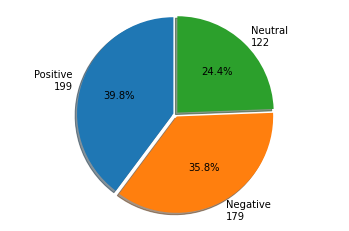

In [ ]:
total, pos, neg, neut = analyze_comments("ubuntu", "microk8s", 500, False, True)

print('Total processed: '+str(total))
print('Positive comments: '+str(pos))
print('Negative comments: '+str(neg))
print('Neutral comments: '+str(neut))

maxc = max(pos, neg, neut)
if maxc == neut:
  print("Communication is mostly neutral.")
  print("In other cases:")
  maxc = max(pos, neg)
if maxc == pos:
  print("Communication is mostly positive.\n")
else:
  print("Communication is mostly negative. Some measures should be considered.\n")

import matplotlib.pyplot as plt

labels = 'Positive\n'+str(pos), 'Negative\n'+str(neg), 'Neutral\n'+str(neut)
sizes = [pos, neg, neut]
explode = (0.025, 0.025, 0.025)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()